### В цикле научиться считывать все картинки из папки.

In [144]:
#folders = [
#    r'D:\Python\Dataset\last\test\images',
#    r'D:\Python\Dataset\last\test\events'
#]

#folders = [
#    r'C:\Users\s21370286\sci.prog\last\31_08_2020_tser1\images',
#    r'C:\Users\s21370286\sci.prog\last\31_08_2020_tser1\events'
#]

#folders = [
#    r'C:\Users\s21370286\sci.prog\last\test\images',
#    r'C:\Users\s21370286\sci.prog\last\test\events'
#]

def bible_and_folders_init(Num):
    import cv2
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from natsort import natsorted
    x = Num
    if x == 1:
        folders = [
            r'D:\Python\Dataset\last\31_08_2020_tser1\images',
            r'D:\Python\Dataset\last\31_08_2020_tser1\events'
        ]
        return folders
    elif x == 2:
        folders = [
            r'D:\Python\Dataset\last\31_08_2020_tser2\images',
            r'D:\Python\Dataset\last\31_08_2020_tser2\events'
        ]
        return folders
    elif x == 3:
        folders = [
            r'D:\Python\Dataset\last\31_08_2020_tser3\images',
            r'D:\Python\Dataset\last\31_08_2020_tser3\events'
        ]
        return folders
    elif x == 4:
        folders = [
            r'D:\Python\Dataset\last\31_08_2020_tser4\images',
            r'D:\Python\Dataset\last\31_08_2020_tser4\events'
        ]
        return folders
    elif x == 5:
        folders = [
            r'D:\Python\Dataset\last\2016-05-18_fileNo11_BM3D_z-max\images',
            r'D:\Python\Dataset\last\2016-05-18_fileNo11_BM3D_z-max\events'
        ]
        return folders
    elif x == 6:
        folders6= [
            r'D:\Python\Dataset\last\2016-05-26_fileNo32_BM3D_z-max\images',
            r'D:\Python\Dataset\last\2016-05-26_fileNo32_BM3D_z-max\events'
        ]
        return folders
    else:
        return None
    

def read_images_from_folders(folders):
    data = []

    for folder in folders:
        folder_name = os.path.basename(folder)
        dataset_name = "images" if "images" in folder_name else "events"
        image_names = natsorted(os.listdir(folder)) #правильная сортировка по цифрам в названии

        for image_name in image_names:
            image_path = os.path.join(folder, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_data = {
                'dataset': dataset_name,
                'image_name': image_name,
                'image_path': image_path,
                'image_size': image.shape if image is not None else None
            }
            data.append(image_data)

    images_df = pd.DataFrame(data)
    return images_df

### 6.7. двумерная матрица: для каждого пикселя максимум интенсивности вычисленный по всем кадрам.

In [145]:
def max_intensity_matrix_for_pixels(df):
    max_intensity = None

    for index, row in df[df['dataset'] == 'images'].iterrows():
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        numpy_image = np.array(image)
        max_intensity = numpy_image if max_intensity is None else np.maximum(numpy_image, max_intensity)

    return max_intensity

### 6.12. максимум интенсивности внутри самой большой области в зависимости от времени.

In [146]:
def find_largest_white_area(image):
    contours, musor = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_area = 0
    largest_area_contour = None

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_area_contour = contour

    pixel_coordinates = []
    if largest_area_contour is not None:

        for pixel in largest_area_contour:
            x, y = pixel[0]
            pixel_coordinates.append((x, y))

    return pixel_coordinates

def find_largest_white_area_from_all_images(df):
    pixel_coordinates_all_images = []

    for image_number, (index, row) in enumerate(df[df['dataset'] == 'events'].iterrows()):
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        pixel_coordinates = find_largest_white_area(image)           
        pixel_coordinates_all_images.append((pixel_coordinates, image_number))

    return pixel_coordinates_all_images

def max_intensities_in_biggest_area_from_all_images(pixel_coordinates_all_images):
    max_intensities = []

    for index, row in df[df['dataset'] == 'images'].iterrows():
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        max_intensity = 0

        for coordinates in pixel_coordinates_all_images[index][0]:
            x, y = coordinates
            intensity = image[y, x]
            if intensity > max_intensity:
                max_intensity = intensity

        max_intensities.append(max_intensity)

    return max_intensities

In [147]:
def graphic_save_and_show(max_intensities_in_area, x):
    time_intervals = np.linspace(0, len(max_intensities_in_area) / 2, 300)
    plt.figure(figsize=(8.27, 3.69), dpi=300)
    plt.plot(time_intervals, max_intensities_in_area, color='#00C78B', linewidth=1.5, label='Максимум интенсивности')
    plt.xlabel('Время (секунд)')
    plt.ylabel('Максимум интенсивности')
    plt.title('График максимумов интенсивности в зависимости от времени')
    plt.legend()
    plt.xlim(time_intervals[0], time_intervals[-1])
    plt.ylim(0, max(max_intensities_in_area) * 1.1)
    plt.grid()
    plt.savefig(f'intensity_max_plot{x}.png', bbox_inches='tight')
    plt.savefig(f'intensity_max_plot{x}.svg', bbox_inches='tight')
    plt.show()

Матрица максимальной интенсивности пикселей :[[116 112 107 ...  45  44  44]
 [120 114 106 ...  44  43  43]
 [123 115 104 ...  44  43  42]
 ...
 [ 63  63  62 ...  95  94  94]
 [ 58  58  58 ...  93  92  91]
 [ 54  54  55 ...  91  90  89]]



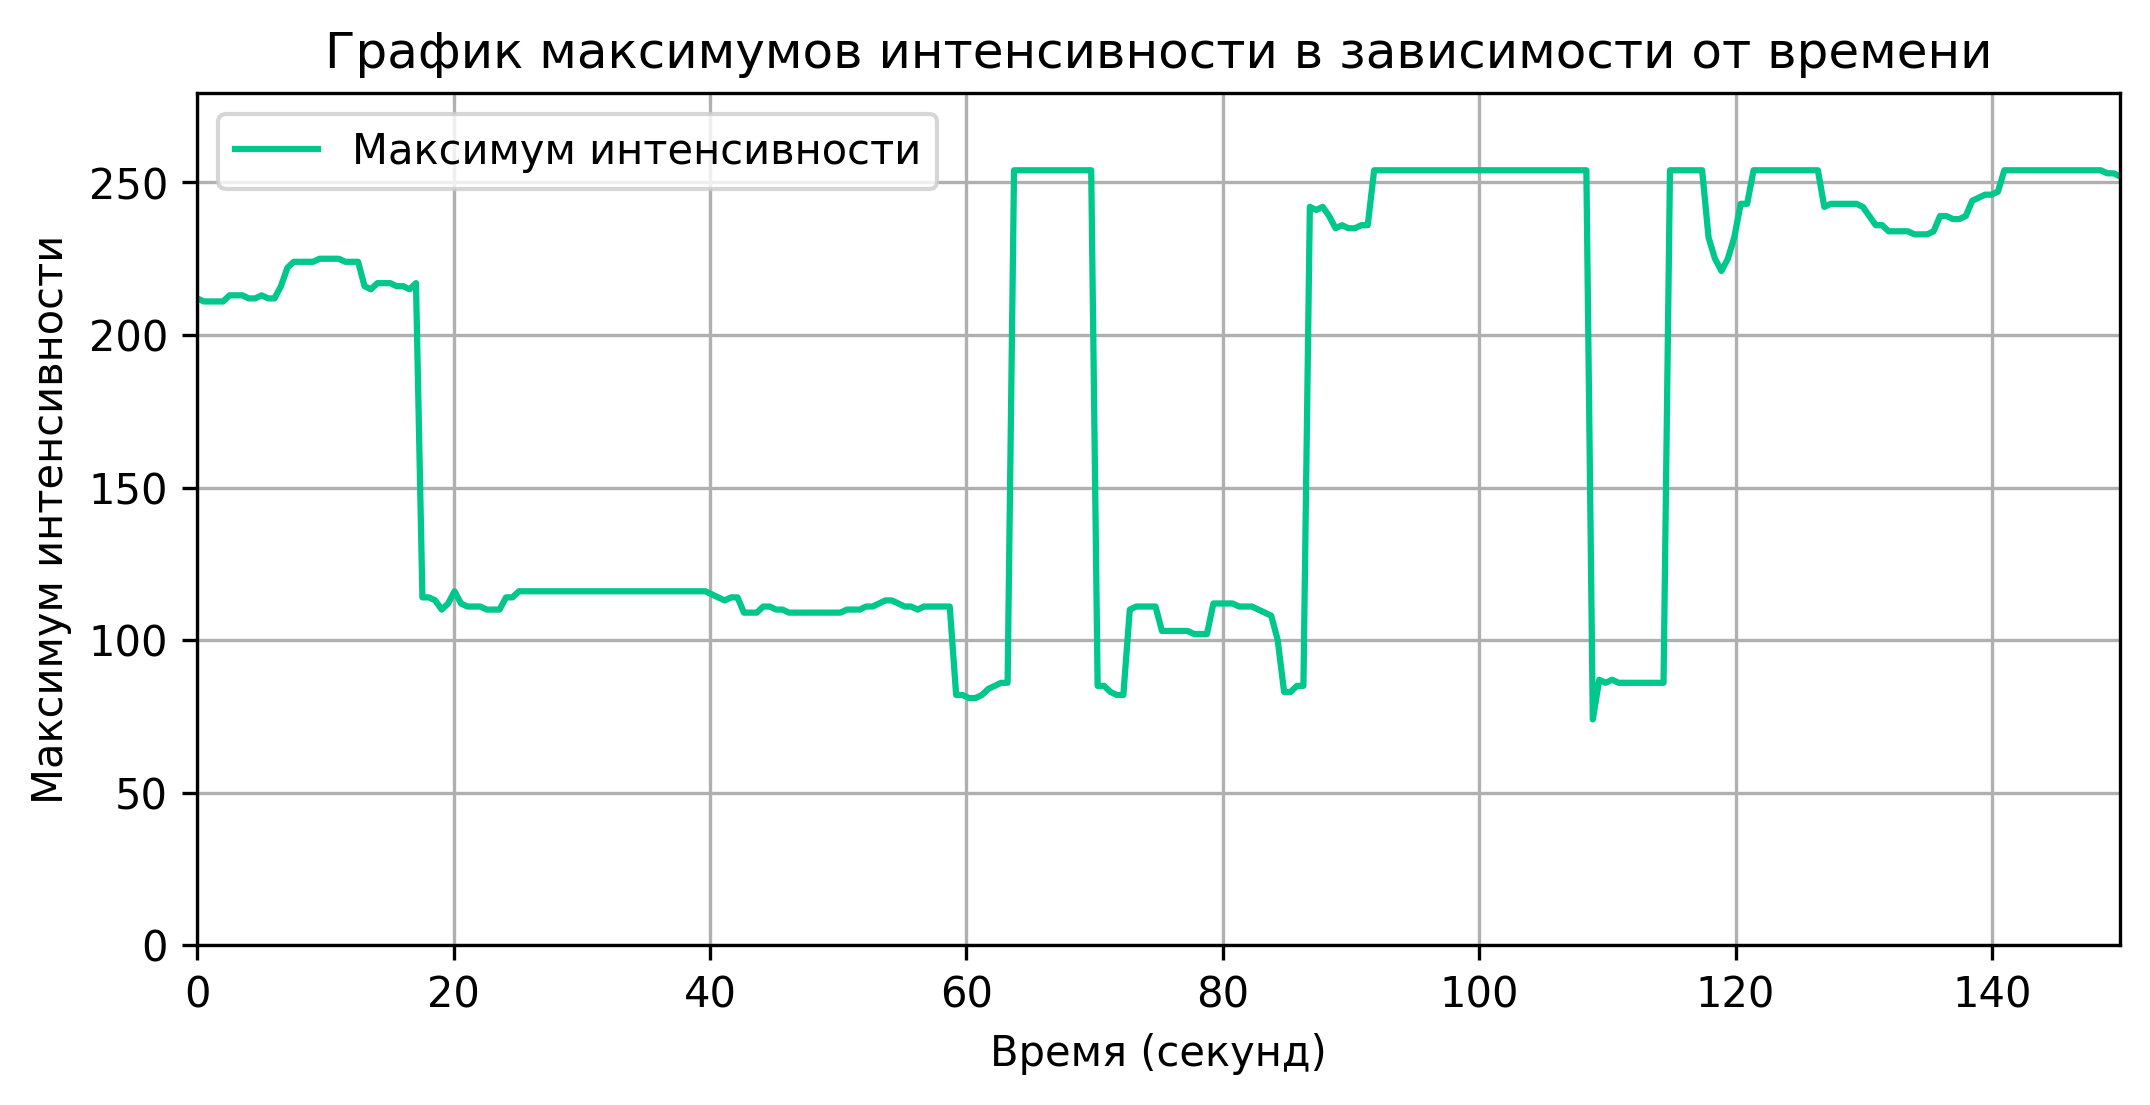

Матрица максимальной интенсивности пикселей :[[ 38  38  39 ... 102 104 106]
 [ 38  39  40 ... 107 109 110]
 [ 39  40  42 ... 112 114 115]
 ...
 [ 85  86  86 ... 114 114 114]
 [ 85  85  86 ... 114 113 113]
 [ 85  85  86 ... 113 113 113]]



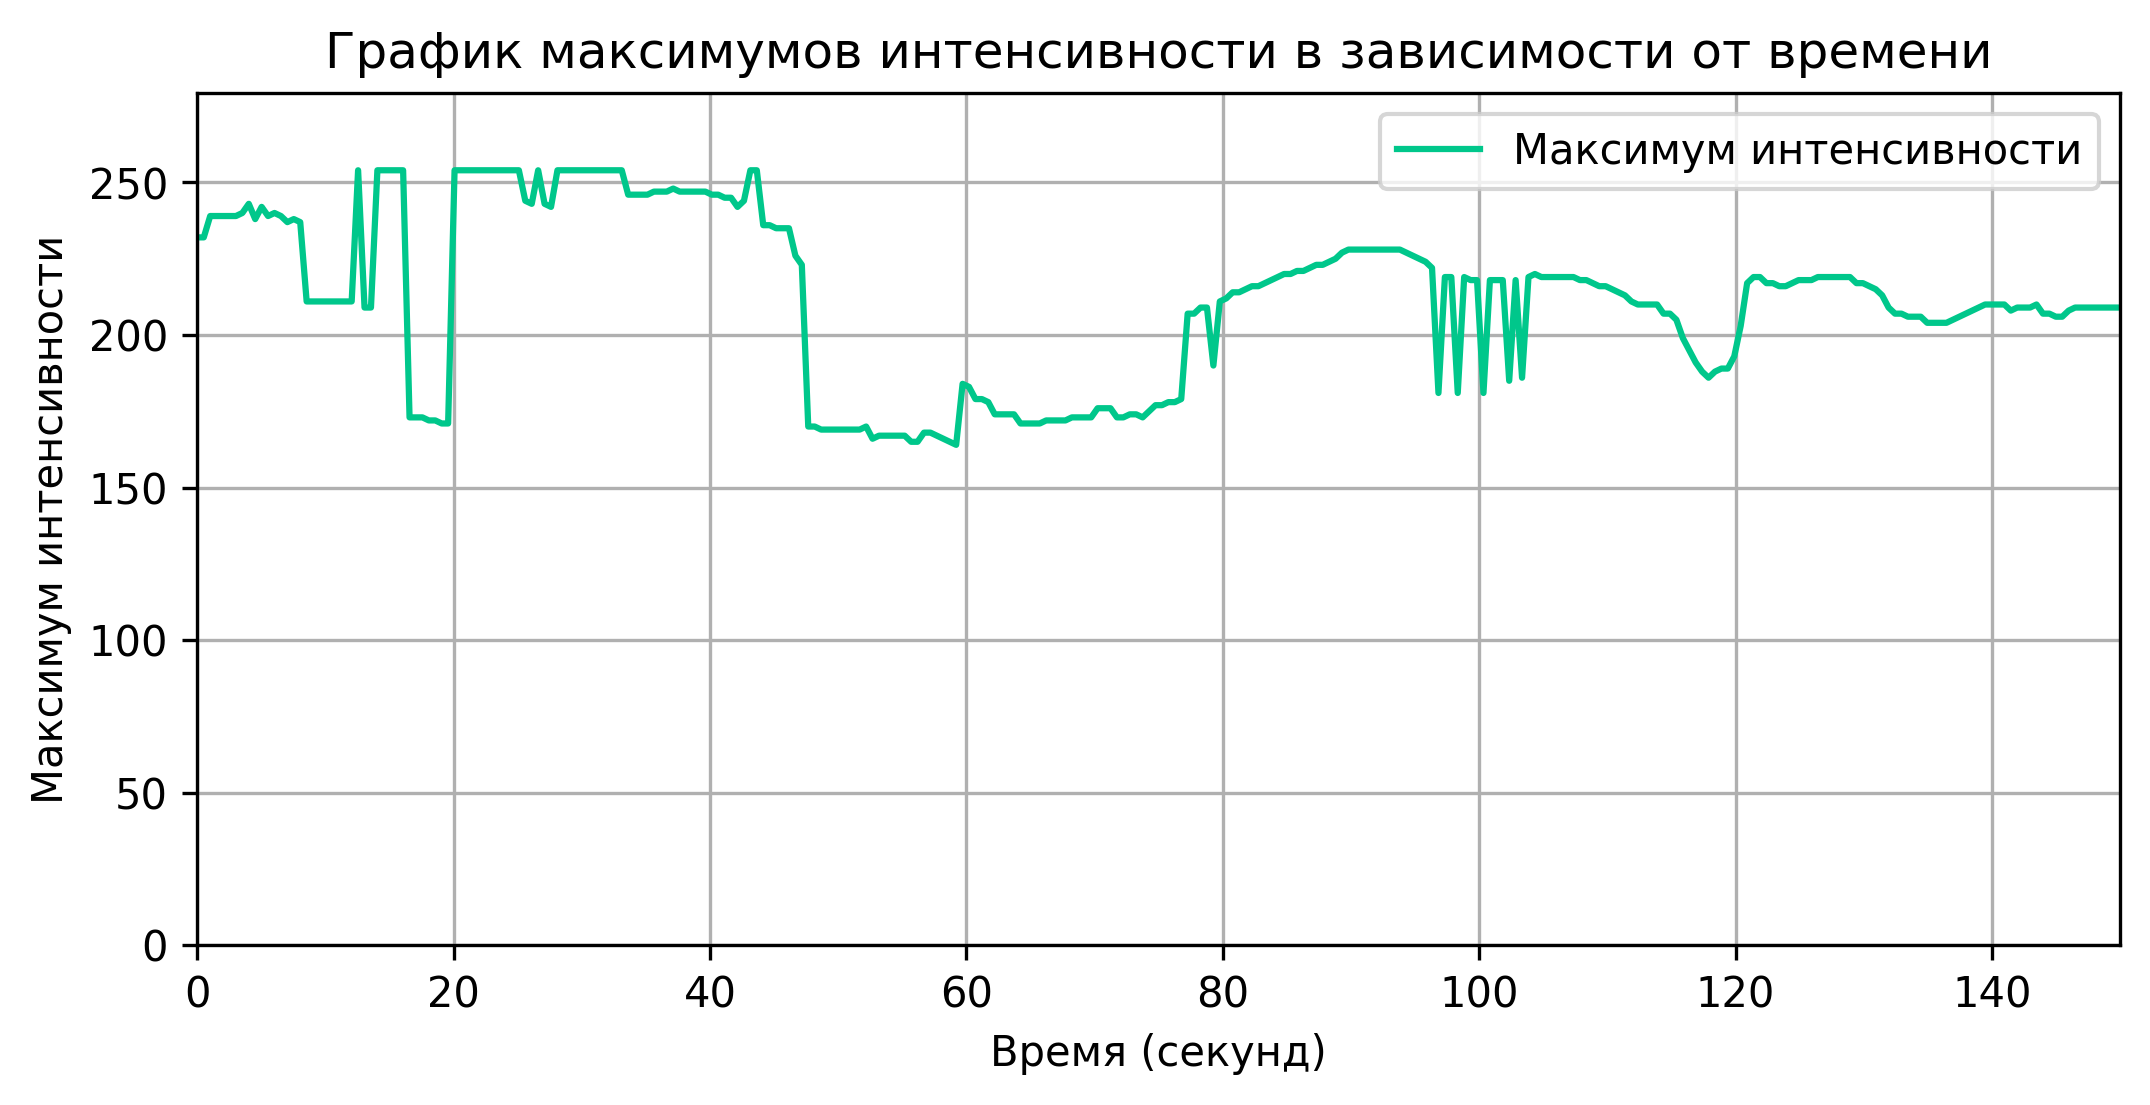

Матрица максимальной интенсивности пикселей :[[ 85  90  96 ...  91  80  72]
 [ 85  90  96 ... 109 100  91]
 [ 86  90  96 ... 124 118 111]
 ...
 [ 63  63  63 ...  48  43  40]
 [ 65  65  64 ...  37  33  31]
 [ 66  66  66 ...  29  27  26]]



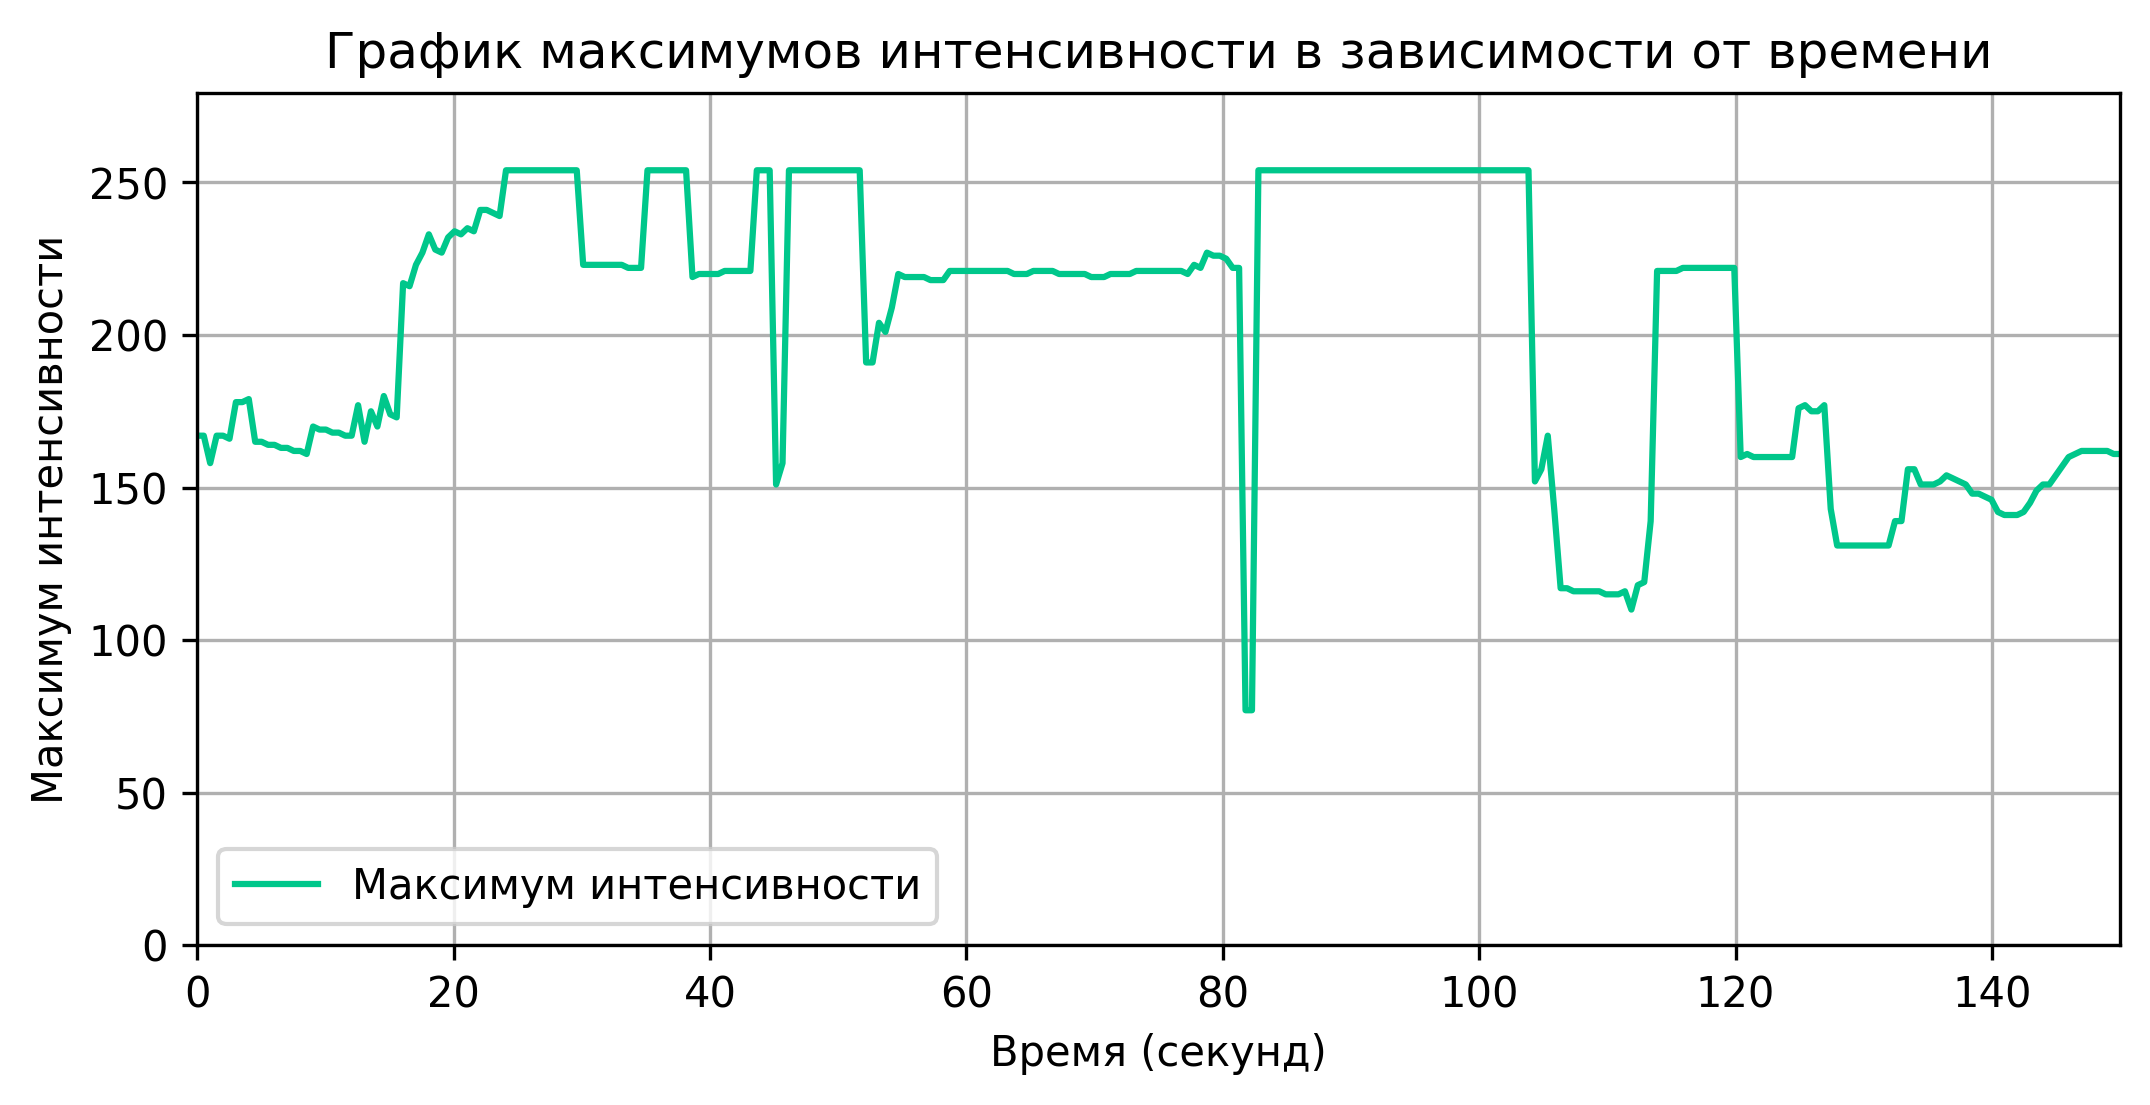

Матрица максимальной интенсивности пикселей :[[57 57 57 ... 60 60 60]
 [55 55 56 ... 60 60 60]
 [53 54 54 ... 61 61 61]
 ...
 [32 32 32 ... 53 53 53]
 [32 32 32 ... 53 53 54]
 [32 32 32 ... 54 54 54]]



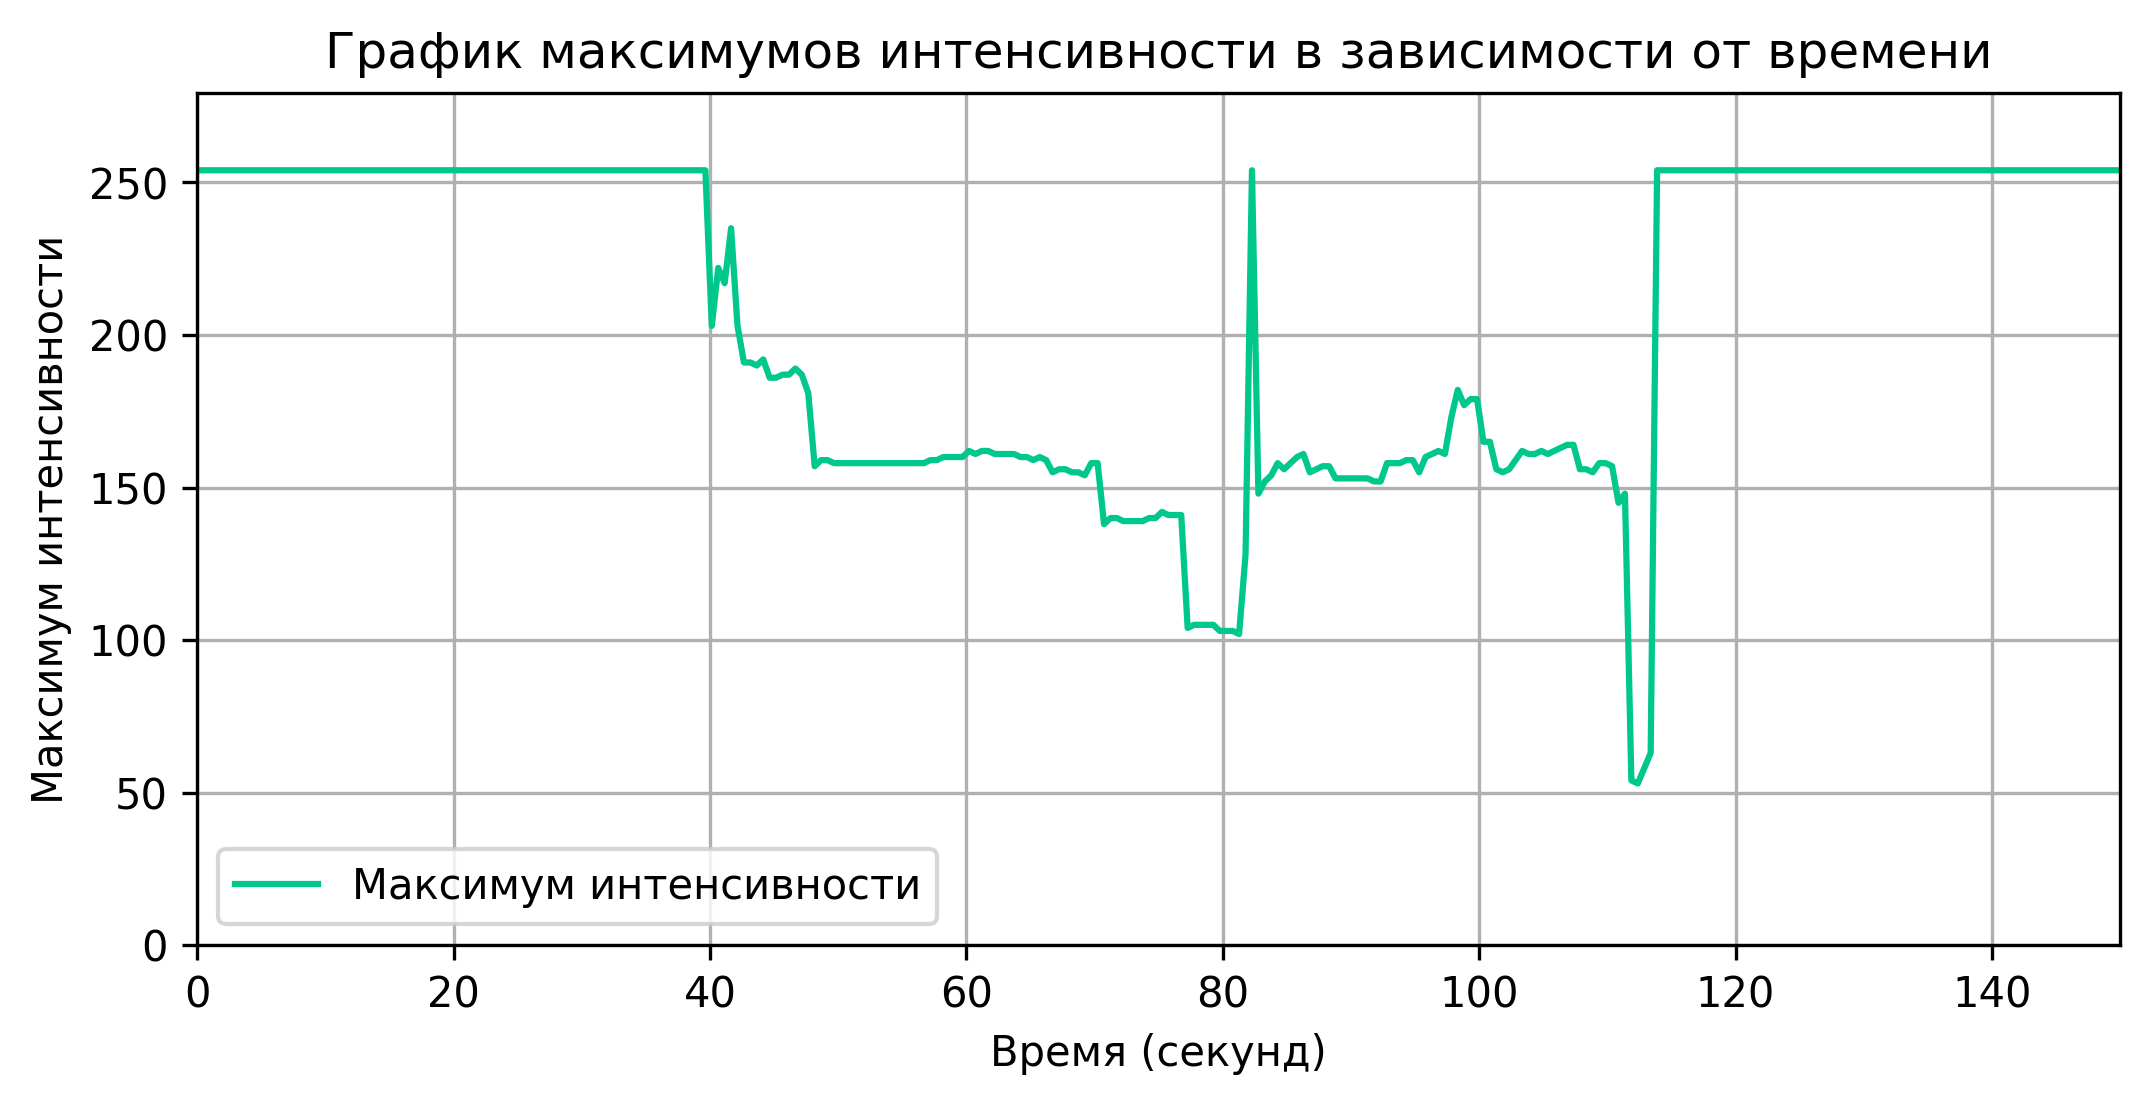

Матрица максимальной интенсивности пикселей :[[3 3 1 ... 4 4 4]
 [3 2 1 ... 4 4 4]
 [3 2 1 ... 3 4 3]
 ...
 [2 2 1 ... 3 3 3]
 [2 2 1 ... 3 3 3]
 [2 2 1 ... 3 3 3]]



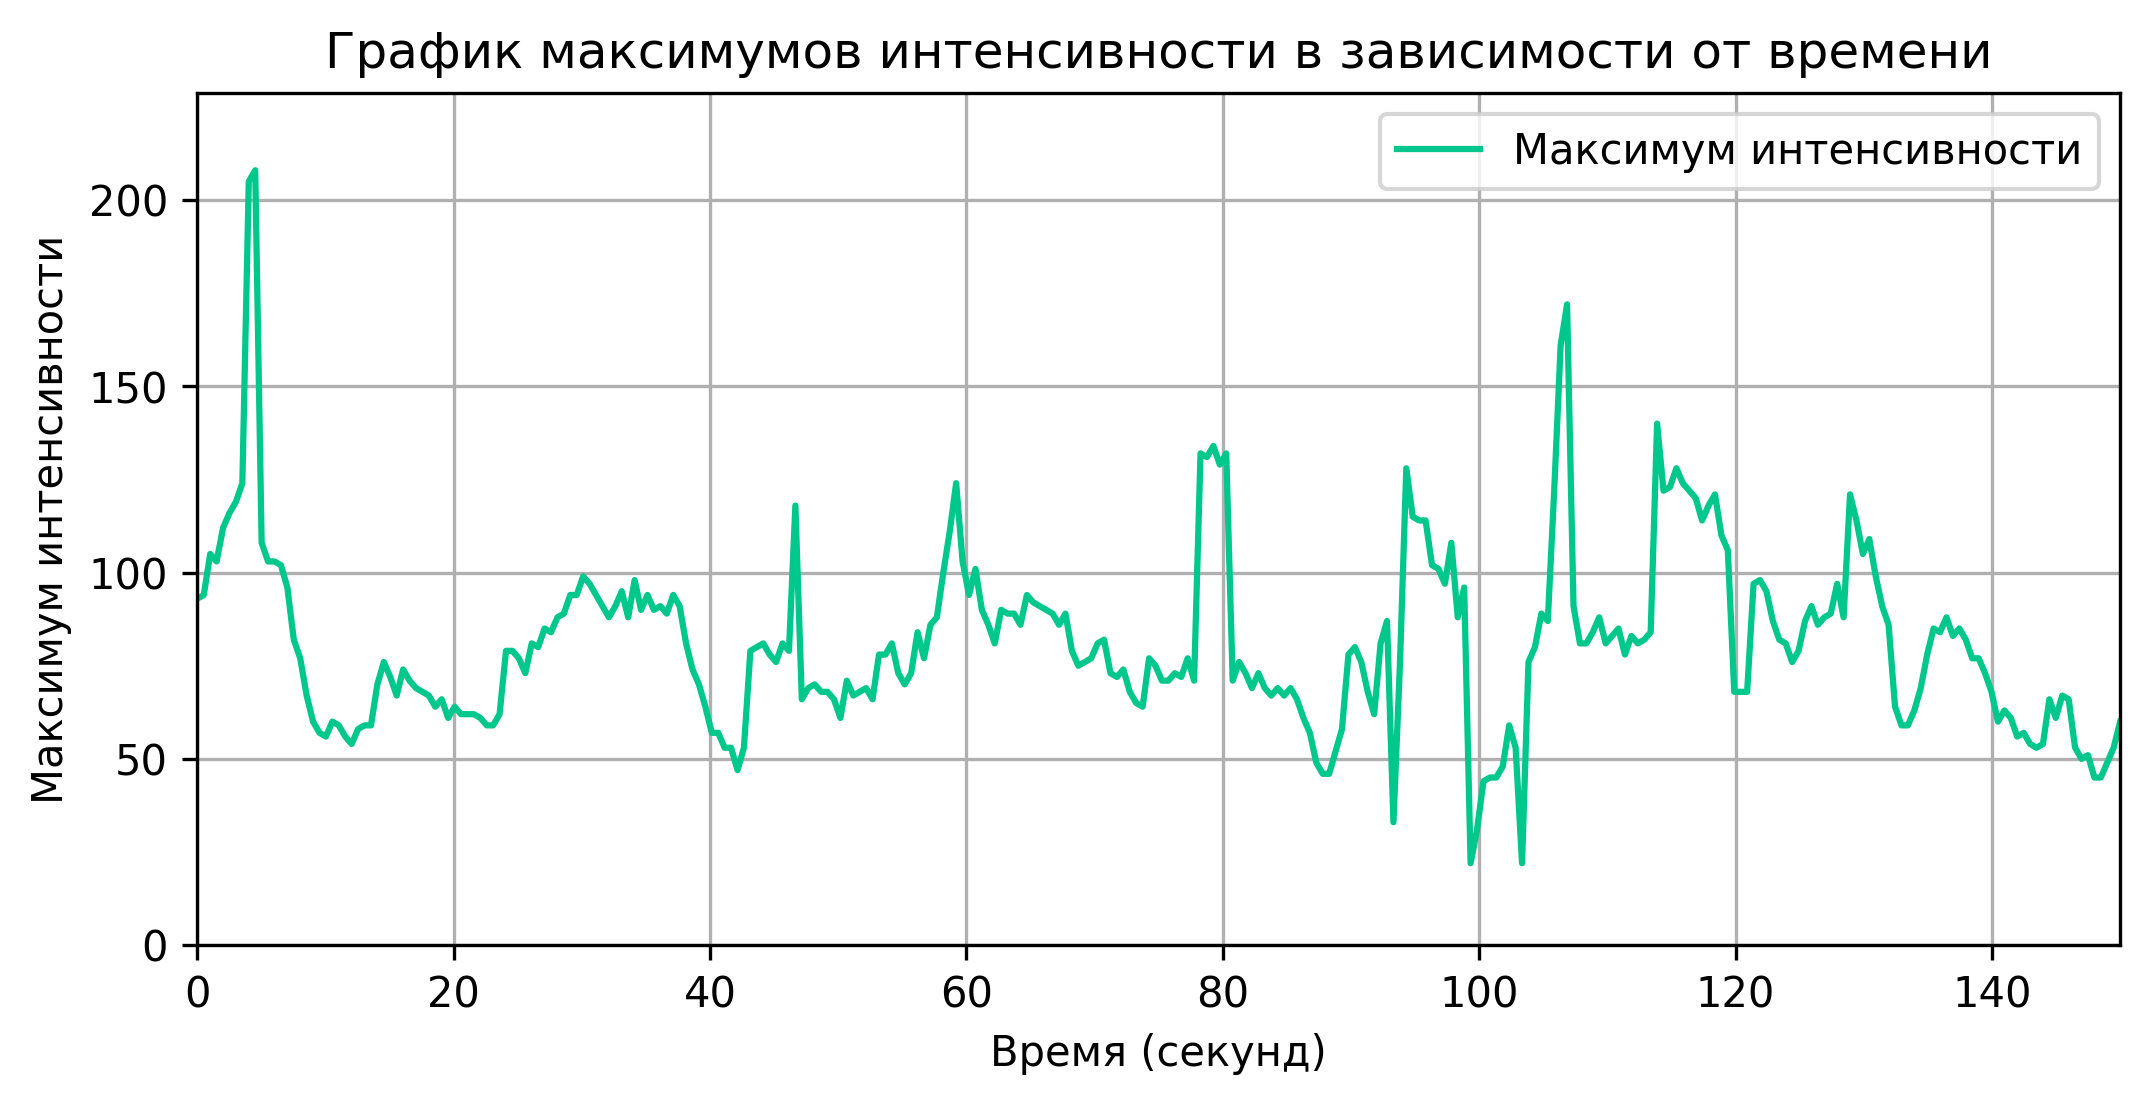

In [148]:
def final_function():
    for x in range(1, 7):
        folders = bible_and_folders_init(x) 
        df = read_images_from_folders(folders)
        print(f"Матрица максимальной интенсивности пикселей :{max_intensity_matrix_for_pixels(df)}\n")
        pixel_coordinates_all_images = find_largest_white_area_from_all_images(df)
        max_intensities_in_area = max_intensities_in_biggest_area_from_all_images(pixel_coordinates_all_images)
        graphic_save_and_show(max_intensities_in_area, x)